# Project 01 - Write a Data Science Blog Post

## Part 3: Data Modeling

### Data
 - NBA 2018-2019 Player Box Scores 
 - NBA 2018-2019 Daily Fantasy Scores (DFS)
 
### Business Questions
1. What are the key drivers for top fantasy scores?
2. What positions offer the most value from a fantasy score perspective?
3. What trends can be observed during the NBA season from a fantasy score perspective?

### Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline

# Use FiveThirtyEight's style of graphs
style.use('fivethirtyeight')

# Use 2 decimal places in output display
pd.options.display.float_format = "{:,.2f}".format

#### Helper Function

In [2]:
def get_feature_importance(regressor, col_names, num_features):
    """
    Takes the Random Forest model, explanatory variable names, and number of features (int) as input.
    
    Returns the feature importances of the model in a dataframe.
    """
    # Get numerical feature importances
    importances = list(regressor.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 20)) for feature, importance in zip(col_names, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse=True)
    feature_importance_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
    return feature_importance_df.head(num_features)

### Import Data

In [3]:
os.chdir('../data')

In [4]:
df = pd.read_csv("Cleaned-Dummies_NBA1819_PlayerStats-DFS.csv")

# Dropping the DRAFTKINGS/FANDUEL columns in favor of YAHOO; unncessary columns
del_cols = ['Unnamed: 0','GAME-ID', 'DATE', 'PLAYER-ID',
            'DRAFTKINGS_FANTASYPOINTS', 'FANDUEL_FANTASYPOINTS',
            'DRAFTKINGS_CLASSIC_SALARY', 'FANDUEL_FULLROSTER_SALARY',
            'YAHOO_FULLSLATE_SALARY']

df.drop(del_cols, axis=1, inplace=True)
df.head()

,MINUTES,USAGE RATE,DAYSREST,YAHOO_FANTASYPOINTS,FG,FGA,3P,3PA,FT,FTA,...,POSITION_C,POSITION_F,POSITION_F-C,POSITION_G,POSITION_G-F,POSITION_PF,POSITION_PG,POSITION_SF,POSITION_SG,POSITION_Unknown
0,22.90,20.38,4,11.70,3,8,0,4,0,0,...,0,0,0,0,0,1,0,0,0,0
1,34.22,14.88,4,22.20,3,10,2,7,0,0,...,0,0,0,0,0,0,0,1,0,0
2,36.82,32.50,4,42.00,9,21,1,4,4,5,...,1,0,0,0,0,0,0,0,0,0
3,24.33,18.98,4,11.60,2,7,0,0,1,2,...,0,0,0,0,0,0,1,0,0,0
4,42.73,21.25,4,64.00,7,14,0,0,5,10,...,0,0,0,0,0,0,1,0,0,0


In [5]:
#df.info(verbose=True, null_counts=True)

In [6]:
# pos_df = df.filter(regex='POSITION')
# pos_df.head()

# player_df = df.filter(regex='PLAYER')
# player_df.head()

### Data Preprocessing

In [7]:
# Split into explanatory and response variables
X = df.drop('YAHOO_FANTASYPOINTS', axis=1) #player_df #pos_df 
y = df['YAHOO_FANTASYPOINTS']

In [8]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# Fit standard scaler to training set
standardscaler = StandardScaler()
standardscaler.fit(X_train)

# Transform the feature variables
X_train_std = standardscaler.transform(X_train)
X_test_std = standardscaler.transform(X_test)

### Instantiate Model

In [10]:
# Instantiate the model
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_std, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [11]:
# Predict and score the model
y_test_preds = rf_regressor.predict(X_test_std)

"The R-squared score for the model using the quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The R-squared score for the model using the quantitative variables was 0.9860399474005086 on 8357 values.'

#### Feature Importance

In [12]:
X_colnames = df.drop(['YAHOO_FANTASYPOINTS'], axis=1).columns
#pos_colnames = pos_df.columns
#player_colnames = player_df.columns

In [14]:
top_features = get_feature_importance(rf_regressor, X_colnames, num_features=10)

# Reformat the column values
top_features.replace({
    'PTS':'Points',
    'TOT':'Total Rebounds',
    'A':'Assists',
    'ST':'Steals',
    'BL':'Blocks',
    'TO':'Turnovers',
    'DR':'Defensive Rebounds',
    'FGA':'Field Goal Attempts'
}, inplace=True)

top_features

,Feature,Importance
0,Points,0.74
1,Total Rebounds,0.10
2,Assists,0.05
3,Steals,0.04
4,Blocks,0.03
5,MINUTES,0.02
6,Turnovers,0.00
7,Defensive Rebounds,0.00
8,USAGE RATE,0.00
9,Field Goal Attempts,0.00


Text(0.5, 0, 'Features')

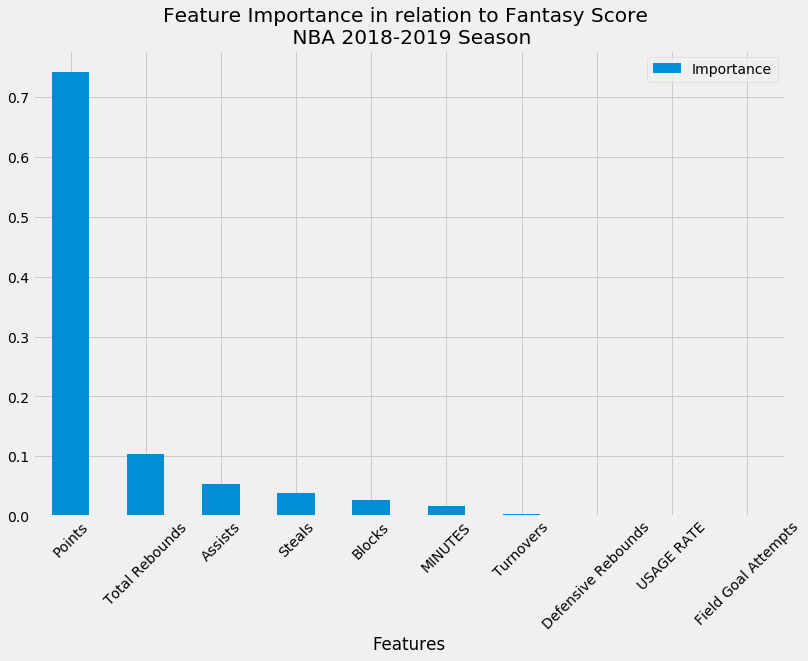

In [15]:
top_features.plot(x='Feature', y='Importance', kind='bar', figsize=(12,8), rot=45)
plt.title('Feature Importance in relation to Fantasy Score \n NBA 2018-2019 Season')
plt.xlabel('Features')
#plt.savefig('../images/FeatureImportance_FantasyScore_NBA1819.png')